In [2]:
# STEP 0 — Setup Kaggle & Install dependencies
!pip install kaggle tqdm tensorflow matplotlib --quiet
from google.colab import files
import os
files.upload()
os.makedirs("/root/.kaggle", exist_ok=True)
os.rename("kaggle.json", "/root/.kaggle/kaggle.json")
os.chmod("/root/.kaggle/kaggle.json", 0o600)
!kaggle datasets download -d vanshikavmittal/fakeddit-dataset -p /content
!unzip -q /content/fakeddit-dataset.zip -d /content/fakeddit

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/vanshikavmittal/fakeddit-dataset
License(s): unknown
  0% 0.00/72.8M [00:00<?, ?B/s]
100% 72.8M/72.8M [00:00<00:00, 1.67GB/s]


In [3]:
# STEP 1 — Import Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from PIL import Image
import requests
from io import BytesIO
from tqdm import tqdm
import glob
import random
import matplotlib.pyplot as plt

In [4]:
# STEP 2 — Set seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [5]:
# STEP 3 — Prepare Folders
base_dir = "/content/fakeddit_images"
os.makedirs(base_dir, exist_ok=True)
train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")
test_dir  = os.path.join(base_dir, "test")
for d in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(d, "real"), exist_ok=True)
    os.makedirs(os.path.join(d, "fake"), exist_ok=True)

In [6]:
# STEP 4 — Load TSV Files
train_df = pd.read_csv("/content/fakeddit/multimodal_only_samples/multimodal_train.tsv", sep="\t")
val_df   = pd.read_csv("/content/fakeddit/multimodal_only_samples/multimodal_validate.tsv", sep="\t")
test_df  = pd.read_csv("/content/fakeddit/multimodal_only_samples/multimodal_test_public.tsv", sep="\t")

train_df = train_df[train_df["hasImage"] == True].dropna(subset=["image_url"])
val_df   = val_df[val_df["hasImage"] == True].dropna(subset=["image_url"])
test_df  = test_df[test_df["hasImage"] == True].dropna(subset=["image_url"])

# Increase sample size for better performance
train_df = train_df.sample(1000, random_state=42)
val_df   = val_df.sample(300, random_state=42)
test_df  = test_df.sample(300, random_state=42)

In [7]:
# STEP 5 — Download images
def download_images(df, folder):
    for _, row in tqdm(df.iterrows(), total=len(df)):
        label = "real" if row["2_way_label"] == 1 else "fake"
        url = row["image_url"]
        filename = os.path.join(folder, label, f"{row['id']}.jpg")
        if os.path.exists(filename):
            continue
        try:
            response = requests.get(url, timeout=8)
            img = Image.open(BytesIO(response.content)).convert("RGB")
            img.save(filename)
        except:
            continue

download_images(train_df, train_dir)
download_images(val_df, val_dir)
download_images(test_df, test_dir)

 35%|███▌      | 354/1000 [00:15<00:28, 22.65it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 300/300 [00:23<00:00, 12.72it/s]


In [8]:
# STEP 6 — Remove corrupted images
def remove_corrupted_images(folder):
    count_removed = 0
    for filename in glob.glob(folder + '/**/*.jpg', recursive=True):
        try:
            img = Image.open(filename)
            img.verify()
        except:
            os.remove(filename)
            count_removed += 1
    print(f"Removed {count_removed} corrupted files.")
remove_corrupted_images(base_dir)

Removed 0 corrupted files.


In [9]:
# STEP 7 — Image Generators
img_size = (224, 224)
batch_size = 16

train_gen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1
).flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=16,
    class_mode='binary'
)

val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 697 images belonging to 2 classes.
Found 208 images belonging to 2 classes.
Found 220 images belonging to 2 classes.


In [10]:
# STEP 8 — Build ResNet50 Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Add, ReLU, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

def resnet_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Shortcut connection
    if stride != 1:
        shortcut = Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

# Input
inp = Input(shape=(224,224,3))
x = Conv2D(32, 3, padding='same', strides=1)(inp)
x = BatchNormalization()(x)
x = ReLU()(x)

# 3 residual blocks → ResNet10-style (small)
x = resnet_block(x, 32)
x = resnet_block(x, 64, stride=2)
x = resnet_block(x, 128, stride=2)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
out = Dense(1, activation='sigmoid')(x)

resnet10_model = Model(inp, out)
resnet10_model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
resnet10_model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 224, 224,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 224, 224,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 224, 224,  │      9,248 │ re_lu[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 224, 224,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 224, 224,  │      9,248 │ re_lu_1[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 224, 224,  │          0 │ add[0][0]         │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │     18,496 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 112, 112,  │     36,928 │ re_lu_3[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 112, 112,  │      2,112 │ re_lu_2[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_4[0][0]  

 Total params: 326,017 (1.24 MB)

 Trainable params: 324,673 (1.24 MB)

 Non-trainable params: 1,344 (5.25 KB)

In [21]:
# STEP 9 — High-Accuracy ResNet50 Fine-Tuning

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# ⚙️ Data Generators (use preprocess_input for ResNet)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.25,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

print("Classes:", train_gen.class_indices)

#  Build Base Model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze most layers first
for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True  # fine-tune last 30 layers

#  Custom Top Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

#  Compile Model
optimizer = Adam(learning_rate=1e-5)  # smaller LR for fine-tuning
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

#  Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=4, min_lr=1e-7, verbose=1)

#  Train Model (More epochs)
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=60,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Save model
model.save("/content/fakenews_resnet50_highacc.h5")

print(" Model training complete. Saved as fakenews_resnet50_highacc.h5.")


Found 697 images belonging to 2 classes.
Found 208 images belonging to 2 classes.
Classes: {'fake': 0, 'real': 1}


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.4684 - loss: 0.9447 - val_accuracy: 0.4808 - val_loss: 0.7154 - learning_rate: 1.0000e-05
Epoch 2/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 505ms/step - accuracy: 0.5401 - loss: 0.7395 - val_accuracy: 0.6106 - val_loss: 0.6697 - learning_rate: 1.0000e-05
Epoch 3/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 499ms/step - accuracy: 0.5422 - loss: 0.7856 - val_accuracy: 0.6298 - val_loss: 0.6623 - learning_rate: 1.0000e-05
Epoch 4/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 495ms/step - accuracy: 0.5906 - loss: 0.7233 - val_accuracy: 0.6250 - val_loss: 0.6593 - learning_rate: 1.0000e-05
Epoch 5/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 496ms/step - accuracy: 0.5531 - loss: 0.7141 - val_accuracy: 0.6635 - val_loss: 0.6521 - learning_rate: 1.0000e-05
Epoch 6/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 495ms/step - accuracy: 0.6011 - loss: 0.6855 - val_accuracy: 0.6394 - val_loss: 0.6480 - learning_rate: 1.0000e-05
Epoch 7/60
22/22 ━━━━━━━━━━━━━━━━━━━━ 11s 495ms/step - accura

 Model training complete. Saved as fakenews_resnet50_highacc.h5.


In [26]:
# STEP 10 — Evaluate and Predict (Fixed)

from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Rebuild test generator properly
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
    classes=['fake', 'real']  # enforce label order consistency
)

# Evaluate
loss, acc = model.evaluate(test_gen)
print(f" Test Accuracy: {acc:.3f} | Test Loss: {loss:.3f}")

# Predict
y_true = test_gen.classes
y_pred = (model.predict(test_gen) > 0.5).astype(int).reshape(-1)

# Optional: check confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=['Fake', 'Real']))


Found 220 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - accuracy: 0.6477 - loss: 0.6148
 Test Accuracy: 0.668 | Test Loss: 0.603
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step
[[68 38]
 [35 79]]
              precision    recall  f1-score   support

        Fake       0.66      0.64      0.65       106
        Real       0.68      0.69      0.68       114

    accuracy                           0.67       220
   macro avg       0.67      0.67      0.67       220
weighted avg       0.67      0.67      0.67       220



In [24]:
# STEP 11 — Confusion Matrix & Classification Report
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=['Fake','Real']))

[[106   0]
 [114   0]]
              precision    recall  f1-score   support

        Fake       0.48      1.00      0.65       106
        Real       0.00      0.00      0.00       114

    accuracy                           0.48       220
   macro avg       0.24      0.50      0.33       220
weighted avg       0.23      0.48      0.31       220



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


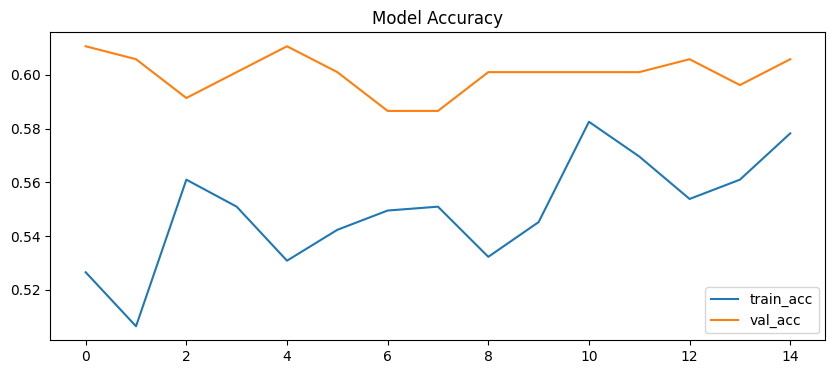

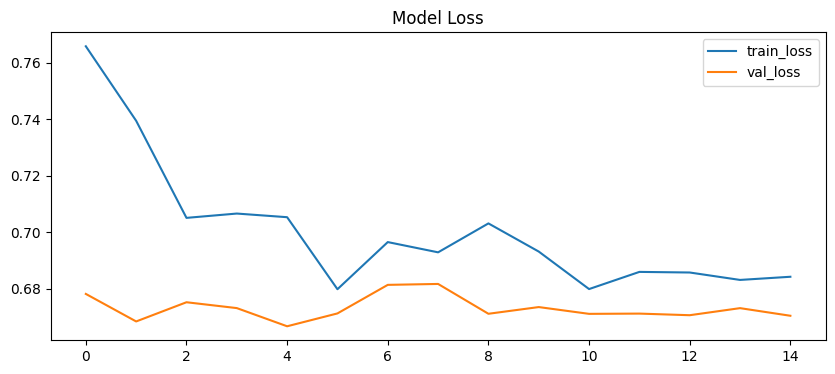

In [16]:
# STEP 12 — Plot Accuracy & Loss
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Model Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.legend()
plt.show()